In [ ]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving dataset.csv to dataset.csv


In [ ]:
data_path = "dataset.csv"

def load_and_clean_data(path):
    print("Loading dataset...")
    df = pd.read_csv(path)

    # Replace infinite values with NaN
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Fill missing values in key columns
    df.fillna(0, inplace=True)

    return df

In [ ]:
def feature_engineering(df):
    print("Performing feature engineering...")

    df['datetime'] = pd.to_datetime(df['datetime'], dayfirst=True)
    df['day_of_year'] = df['datetime'].dt.dayofyear
    df['hour'] = df['datetime'].dt.hour
    df['temp_stress'] = np.maximum(df['HiTemp'] - 25, 0)
    df['humidity_stress'] = df['OutHum'] * df['Rain'].fillna(0)
    df['solar_exposure'] = df['SolarRad'] / df['HiSolarRad'].replace(0, 1e-6)
    df['voltage_drop_stress'] = (df['V_MAX'] - df['V_MIN']) / df['V_MAX'].replace(0, 1e-6)

    # Cumulative calculations
    df['cumulative_solar_exposure'] = df.groupby('SerialNo')['solar_exposure'].cumsum()
    df['cumulative_temp_stress'] = df.groupby('SerialNo')['temp_stress'].cumsum()
    df['cumulative_humidity_stress'] = df.groupby('SerialNo')['humidity_stress'].cumsum()

    return df

In [ ]:
def preprocess_data(df):
    print("Preprocessing data...")

    # Drop unnecessary columns
    cols_to_drop = ['SerialNo', 'Substation_x', 'datetime', 'Site']
    df.drop(columns=cols_to_drop, errors='ignore', inplace=True)

    # Handle categorical columns
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    for col in categorical_cols:
        df[col] = LabelEncoder().fit_transform(df[col])

    # Handle missing values
    imputer = SimpleImputer(strategy='median')
    X = imputer.fit_transform(df.drop(columns=['degradation'], errors='ignore'))
    y = df['degradation'].values

    # Remove NaNs in target
    mask = ~np.isnan(y)
    X, y = X[mask], y[mask]

    # Feature scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y, scaler, imputer, df.drop(columns=['degradation']).columns.tolist()

In [ ]:
def train_model(X_train, y_train):
    print("Training model...")
    model = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_leaf=5, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    return model

In [ ]:
def evaluate_model(model, X_test, y_test):
    print("Evaluating model...")
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")

    return y_test, y_pred

In [ ]:
def save_model(model, scaler, imputer, feature_names):
    with open("solar_model.pkl", "wb") as f:
        pickle.dump({'model': model, 'scaler': scaler, 'imputer': imputer, 'features': feature_names}, f)
    print("Model saved as solar_model2.pkl")

In [ ]:
def generate_plots(y_test, y_pred):
    print("Generating plots...")

    # 1️⃣ Heatmap of Feature Correlation
    plt.figure(figsize=(10, 6))
    sns.heatmap(pd.DataFrame(X_test, columns=feature_names).corr(), cmap='coolwarm', annot=False)
    plt.title('Feature Correlation Heatmap')
    plt.show()

    # 2️⃣ Actual vs. Predicted Values
    plt.figure(figsize=(10, 5))
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual Degradation")
    plt.ylabel("Predicted Degradation")
    plt.title("Actual vs. Predicted Degradation")
    plt.show()

    # 3️⃣ Error Distribution
    errors = y_test - y_pred
    sns.histplot(errors, bins=30, kde=True)
    plt.title("Prediction Error Distribution")
    plt.show()

    # 4️⃣ Waveform Plot
    plt.figure(figsize=(12, 5))
    plt.plot(y_pred[:100], label="Predicted", linestyle="dashed")
    plt.plot(y_test[:100], label="Actual")
    plt.legend()
    plt.title("Waveform of Degradation")
    plt.show()

    # 5️⃣ Box Plot
    sns.boxplot(y_test - y_pred)
    plt.title("Boxplot of Prediction Errors")
    plt.show()

    # 6️⃣ Density Plot
    sns.kdeplot(y_test, label="Actual", shade=True)
    sns.kdeplot(y_pred, label="Predicted", shade=True)
    plt.title("Density Plot of Degradation")
    plt.legend()
    plt.show()

    # 7️⃣ 3D Scatter Plot
    fig = px.scatter_3d(x=y_test, y=y_pred, z=errors, title="3D Error Visualization")
    fig.show()

    # 8️⃣ Regression Line Plot
    sns.regplot(x=y_test, y=y_pred, line_kws={"color": "red"})
    plt.title("Regression Line")
    plt.show()

    # 9️⃣ Violin Plot
    sns.violinplot(y_test - y_pred)
    plt.title("Violin Plot of Prediction Errors")
    plt.show()

    # 🔟 Interactive 3D Surface Plot
    fig = go.Figure(data=[go.Surface(z=np.outer(y_test[:20], y_pred[:20]))])
    fig.update_layout(title="3D Surface of Predictions", autosize=False, width=700, height=500)
    fig.show()

Loading dataset...
Performing feature engineering...
Preprocessing data...
Training model...
Evaluating model...
MAE: 0.0032
RMSE: 0.0049
R² Score: 1.0000
Model saved as solar_model2.pkl
Generating plots...


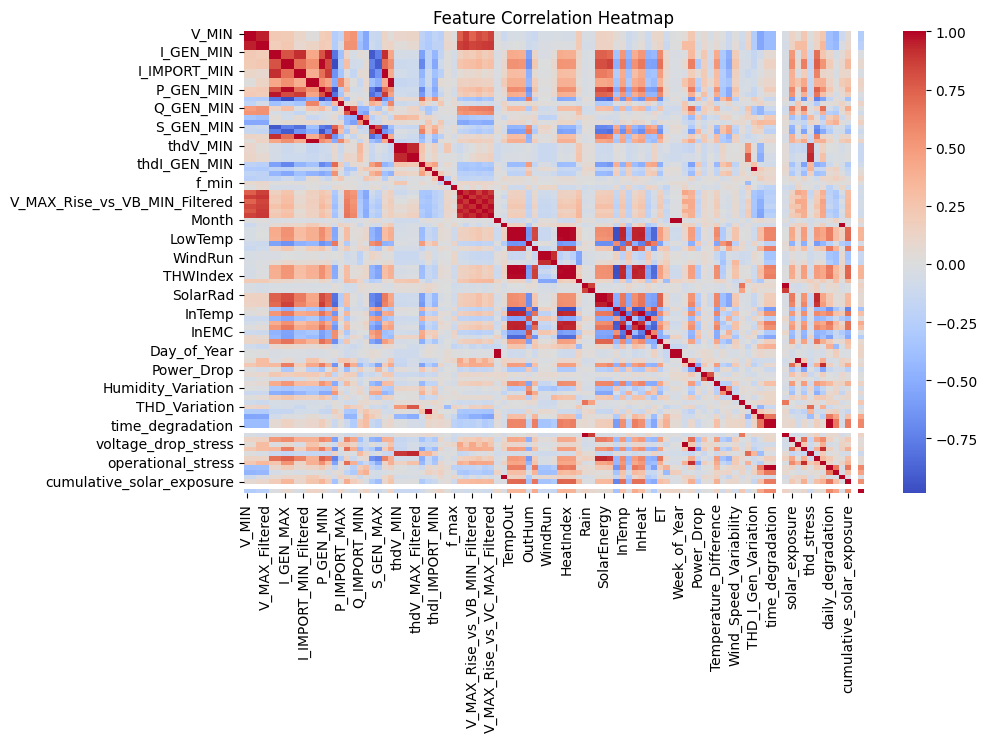

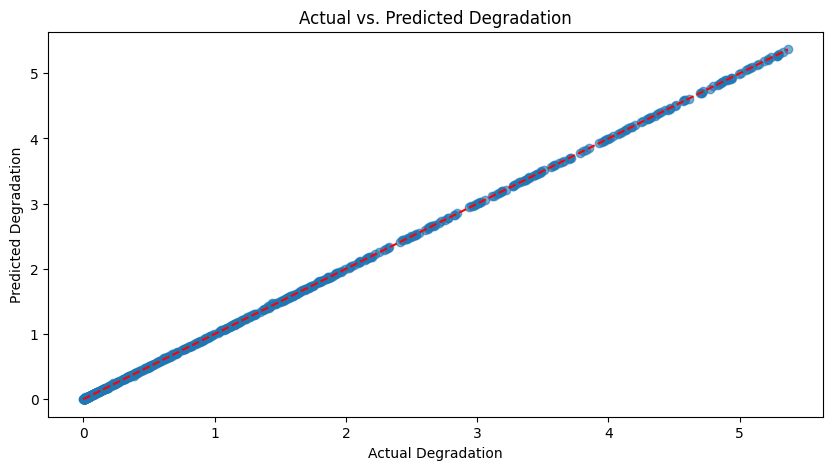

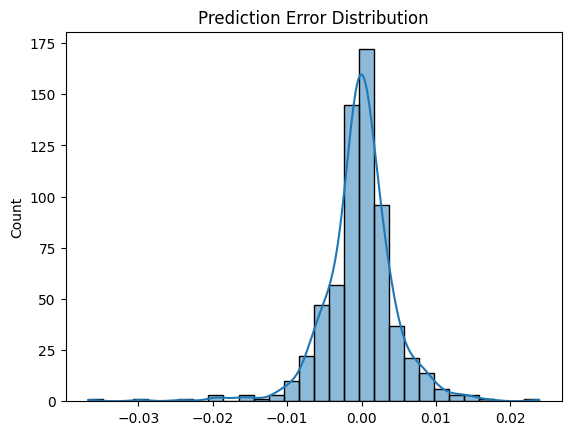

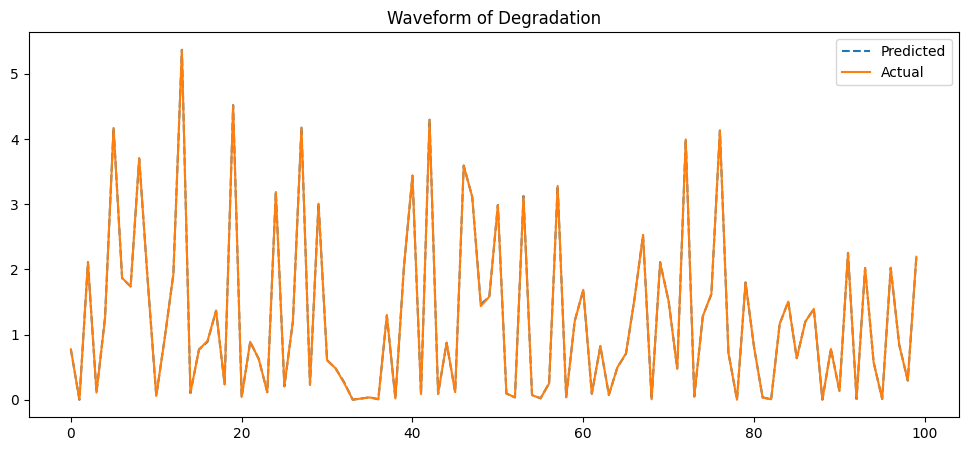

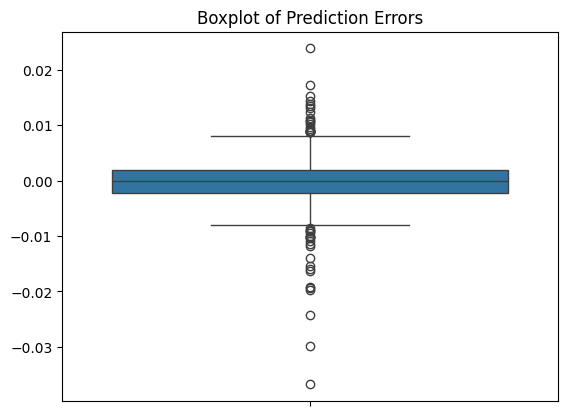

/tmp/ipython-input-585683124.py:39: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_test, label="Actual", shade=True)
/tmp/ipython-input-585683124.py:40: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_pred, label="Predicted", shade=True)


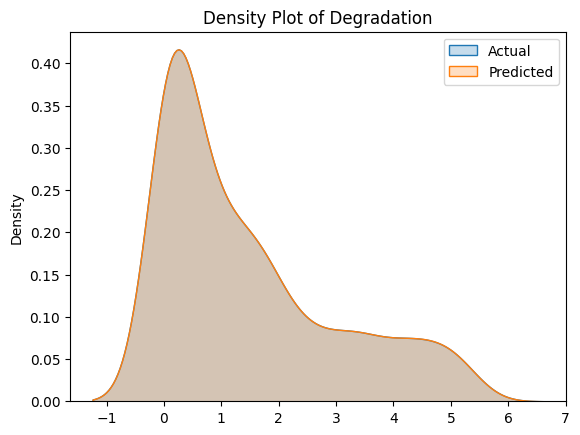

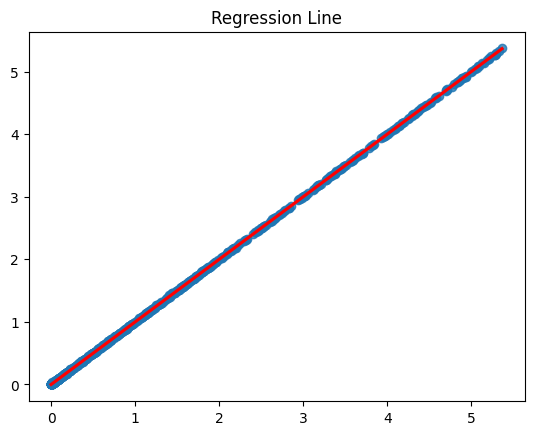

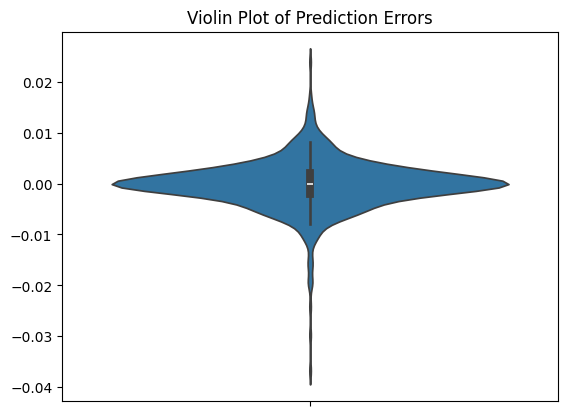

In [ ]:
if __name__ == "__main__":
    df = load_and_clean_data(data_path)
    df = feature_engineering(df)
    X, y, scaler, imputer, feature_names = preprocess_data(df)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = train_model(X_train, y_train)
    y_test, y_pred = evaluate_model(model, X_test, y_test)

    save_model(model, scaler, imputer, feature_names)

    generate_plots(y_test, y_pred)

In [ ]:
import pickle
import pandas as pd

def load_model():
    with open("solar_model.pkl", "rb") as f:
        data = pickle.load(f)
    return data['model'], data['scaler'], data['imputer'], data['features']

def predict_degradation(user_input):
    model, scaler, imputer, feature_names = load_model()

    df_input = pd.DataFrame([user_input], columns=feature_names)
    df_input = imputer.transform(df_input)
    df_input_scaled = scaler.transform(df_input)

    return model.predict(df_input_scaled)[0]

# User input for prediction
user_data = {
    'Power_to_Solar_Ratio': 0.8,
    'Apparent_Power_Ratio': 1.2,
    'day_of_year': 150,
    'hour': 14,
    'temp_stress': 2.0,
    'humidity_stress': 0.5,
    'solar_exposure': 0.7,
}

prediction = predict_degradation(user_data)
print(f"Predicted Degradation: {prediction:.4f}")

Predicted Degradation: 1.3579
